# Debugging singing extraction from recordings

In [26]:
# Before starting, set the right working dir and imports
import os
if 'path_to_dir' not in globals():
    path_to_dir = os.path.split(os.getcwd())[0]
os.chdir(path_to_dir)

# imports
import numpy as np
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

from sing4me import singing_extract as sing
from sing4me.melodies import as_native_type, convert_absolute_pitches_to_interval_sequence

In [27]:
# Global parameters
from params import singing_2intervals as config
print(config["reference_mode"])

pitch_mode


## Analysis

In [28]:
# import recordings
# recording_file='example1.wav'
# recording_file='example2.wav'
recording_file='example3.wav'
plot_file_name = f"plot_{recording_file}.png"

# add target pitches
target_pitches = [50, 54, 57, 53, 52]  
reference_pitch = 50

In [29]:
# analyse
import tempfile
import parselmouth

def recode_wav(file_path):
    with tempfile.NamedTemporaryFile() as temp_file:
        shutil.copyfile(file_path, temp_file.name)
        s = parselmouth.Sound(temp_file.name)
        s.save(file_path, "WAV")

recode_wav(os.path.join("input/", recording_file))

print(target_pitches)

[50, 54, 57, 53, 52]


In [31]:
# compute sung pitches and intervals5
raw = sing.analyze(
    os.path.join("input/",recording_file),
    config,
    target_pitches=target_pitches,
    plot_options=sing.PlotOptions(
        save=True,
        path= os.path.join("output", plot_file_name),
        format="png"
    ),
)

raw = [{key: as_native_type(value) for key, value in x.items()} for x in raw]
sung_pitches = [x["median_f0"] for x in raw]
sung_intervals = convert_absolute_pitches_to_interval_sequence(
            sung_pitches,
             "previous_note"
        )

target_intervals = convert_absolute_pitches_to_interval_sequence(
    target_pitches,
    "previous_note"
)
stats = sing.compute_stats(
    sung_pitches,
    target_pitches,
    sung_intervals,
    target_intervals
)
print(f"sung pitches: {sung_pitches}")
print(f"target pitches: {target_pitches}")
print(f"sung intervals: {sung_intervals}")
print(f"target intervals: {target_intervals}")


print(f"stats: {stats}")

selected$("Sound")Plot saved
sung pitches: [53.52632898046403, 59.82105652667491, 53.06077966673817]
target pitches: [50, 54, 57, 53, 52]
sung intervals: [6.294727546210879, -6.760276859936738]
target intervals: [4, 3, -4, -1]
stats: {'num_sung_pitches': 3, 'num_target_pitches': 5, 'raw_pitch_diffs': [3.5263289804640294, 5.821056526674909, -3.9392203332618294], 'mean_pitch_diffs': 1.8027217246257028, 'max_abs_pitch_error': 5.821056526674909, 'root_mean_squared_pitch': 4.5400863427615, 'raw_interval_diffs': [2.294727546210879, -9.760276859936738], 'mean_interval_diff': -3.7327746568629294, 'max_abs_interval_error': 9.760276859936738, 'root_mean_squared_interval': 7.089738320063567, 'direction_accuracy': 25.0}


In [32]:
# extract onsets

MIN_NOTE_DURATION = 0.25

silence_durations, note_durations, ISIs = sing.extract_onsets(raw, MIN_NOTE_DURATION)
print(f"note_durations: {note_durations}")
print(f"silence_durations: {silence_durations}")
print(f"ISIs: {ISIs}")


note_durations: [0.488843537414966, 0.5154648526077099, 0.6844444444444443]
silence_durations: [0.25, 0.25, 0.5]
ISIs: [0.738843537414966, 0.7654648526077099]


In [33]:
is_failed = melodies.failing_criteria(
    sung_intervals,
    sung_pitches,
    reference_pitch,
    config["num_int"],
    config["max_interval_size"],
    config["max_melody_pitch_range"],
    config["reference_mode"],
    stats,
    config["max_abs_interval_error_treshold"],
    config["max_pitch_height"]
)
print(f"Failing Criteria: {is_failed}")

Failing Criteria: {'failed': True, 'reason': 'Wrong number of sung notes: 3  sung out of 5 notes in melody'}


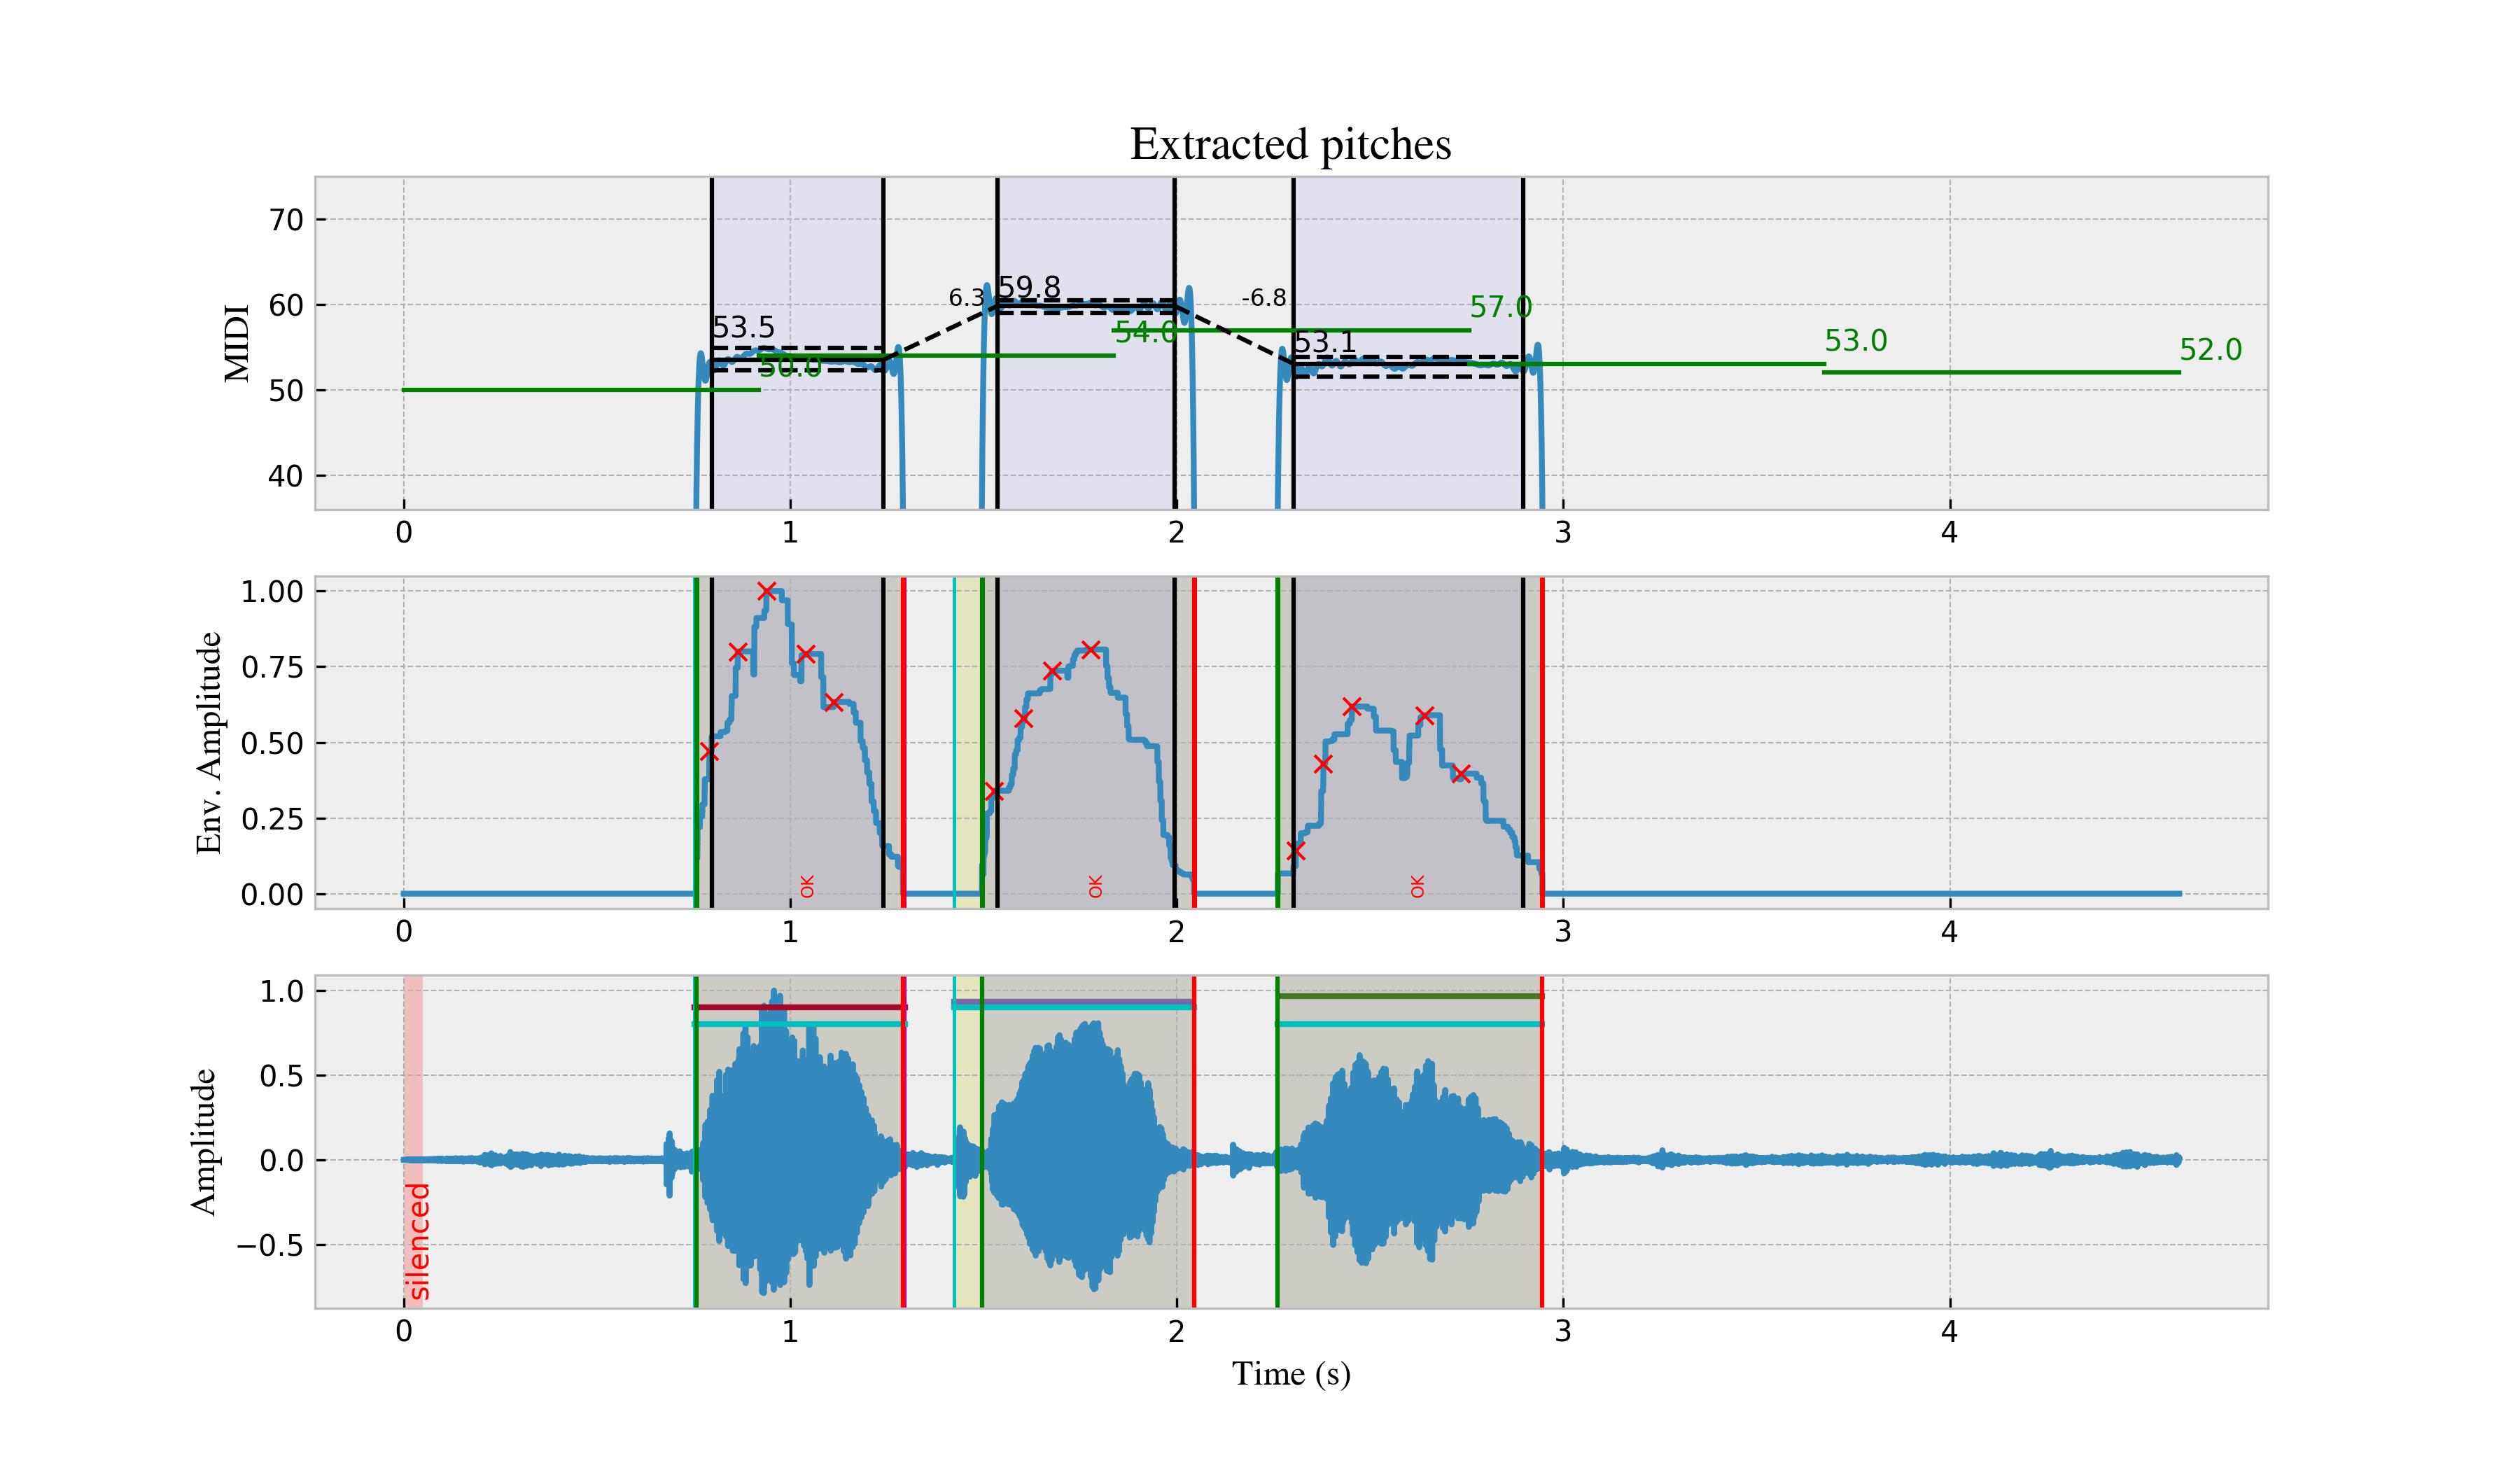

In [34]:
from IPython import display
display.Image(os.path.join("output", plot_file_name))